In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
import numpy as np

In [2]:
from keras.models import model_from_json
# load json and create model
json_file = open('/home/madhumadi/sd/srcnn_tjf_ds_full_elevation_1_e_1000/srcnn_pred_srcnn_tjf_ds_full_elevation_1_e_1000_16_06.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/home/madhumadi/sd/srcnn_tjf_ds_full_elevation_1_e_1000/srcnn_weights_srcnn_tjf_ds_full_elevation_1_e_1000_16_06.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error',optimizer='adam')

Using TensorFlow backend.


Loaded model from disk


In [3]:

data_size=-1 #train+test
batch_size=100 # Size of each batch
n_epochs=1000
use_elevation=1
patience=100
if data_size== -1:
    ds='full'
else:
    ds=data_size


In [4]:
import xarray as xr
y=xr.open_dataset('/home/madhumadi/sd/nc_files/obs_1920_to_2005_no_leap.nc')['precipitation (mm)'].sel(time=slice('1950-01-01','2005-12-31')).fillna(0)


In [5]:
y.shape 

(20440, 129, 135)

In [6]:
path='/home/madhumadi/bcsd_bcsrcnn/NorESM1_M/bcsd/'
model_file_name='NorESM1_bcsd_rcp_85.nc'

In [7]:
t=xr.open_dataset(path+model_file_name)
t

<xarray.Dataset>
Dimensions:              (lat: 117, lon: 118, time: 34675)
Coordinates:
  * lat                  (lat) float64 8.25 8.5 8.75 9.0 ... 36.75 37.0 37.25
  * time                 (time) object 2006-01-01 00:00:00 ... 2100-12-31 00:00:00
  * lon                  (lon) float64 68.0 68.25 68.5 ... 96.75 97.0 97.25
Data variables:
    NorESM1_bcsd_rcp_85  (time, lat, lon) float64 ...
Attributes:
    units:    mm/day
    name:     NorESM1_bcsd_rcp_85
    rcp:      RCP_85

In [9]:
model_temp=t['NorESM1_bcsd_rcp_85'].fillna(0)

In [10]:
model_t=model_temp.sel(time=~((model_temp.time.dt.month == 2) & (model_temp.time.dt.day == 29)))

In [11]:
model_t.shape

(34675, 117, 118)

In [12]:
print(model_t.time.values[0])

2006-01-01 00:00:00


In [13]:
print(model_t.time.values[-1])

2100-12-31 00:00:00


In [14]:
model=model_t#.sel(time=slice('1981-01-01','2005-12-31'))

In [15]:
model

<xarray.DataArray 'NorESM1_bcsd_rcp_85' (time: 34675, lat: 117, lon: 118)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]])
Coordinates:
  * lat      (lat) float64 8.25 8.5 8.75 9.0 9.25 ... 36.5 36.75 37.0 37.25
  * time     (time) object 2006-01-01 00:00:00 ... 2100-12-31 00:00:00
  * lon      (lon) float64 68.0 68.25 68.5 68.75 69.0 ... 96.5 96.75 97.0 97.25

In [16]:
mask=xr.where(xr.open_dataset('nc_files/obs_1920_to_2005_no_leap.nc')['precipitation (mm)'][0]>=0,1,np.nan)

In [17]:
mask#.plot()

<xarray.DataArray 'precipitation (mm)' (lat: 129, lon: 135)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
    time     datetime64[ns] 1920-01-01

In [18]:

temp=model.interp_like(mask)

In [19]:
temp[1].fillna(0).plot()

In [20]:

x=temp.fillna(0)
train_images=np.asarray(x)

In [21]:
train_images[0].shape

(129, 135)

In [22]:

if use_elevation==1:
    import xarray as xr
    from numpy import *
    a='/home/madhumadi/sd/nc_files/india_masked_ele_interp.nc'
    elevation=xr.open_dataset(a)
    elevation_temp2=elevation.interp(lon=np.arange(66.5,100.0,0.25), lat=np.arange(6.5,38.5,0.25))

    felev_temp=np.asarray(elevation_temp2['Band1']).reshape([128,134])

    def fill_na(x, fillval=0):
        where_are_NaNs = isnan(x)
        x[where_are_NaNs] = fillval
        return x
    felev_te=fill_na(felev_temp)
    felev=((felev_te-np.min(felev_te))/(np.max(felev_te)-np.min(felev_te)))

    train_images.shape
    p1=[]
    for i in range(len(train_images)):
        p2=np.asarray([train_images[i,0:128,0:134],felev*50])
        p1.append(p2)
    p3=np.asarray(p1)
    print(p3.shape)
    resu=p3.transpose(0,2,3,1)
    print(resu.shape)


(34675, 2, 128, 134)
(34675, 128, 134, 2)


In [23]:
resu.shape

(34675, 128, 134, 2)

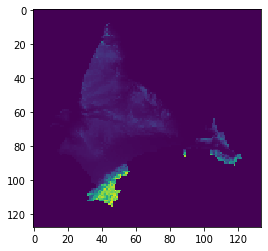

In [24]:
import pylab as plt
plt.imshow(resu[0,:,:,1])

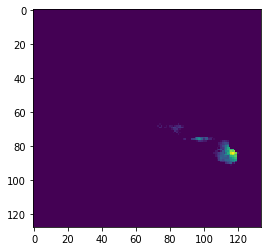

In [25]:
plt.imshow(resu[0,:,:,0])

In [26]:
predictions=loaded_model.predict(resu)

In [27]:
predictions.shape

(34675, 128, 134, 1)

In [36]:
name_of_variable='NorESM1_bcsrcnn_rcp_85'
start_time='2006-01-01'
end_time='2100-12-31'
rcp_name='rcp_85'
#start_time='1981-01-01'
#end_time='2005-12-31'

In [37]:
predict=predictions.reshape([-1,128,134])
xr_object = xr.Dataset({name_of_variable: (('time', 'lat', 'lon'), predict)},coords={"lat": np.arange(6.5,38.5,0.25), "lon":np.arange(66.5,100.0,0.25), "time": xr.cftime_range(start_time,end_time, calendar='noleap')})
xr_object.attrs['units'] = 'mm/day'
xr_object.attrs['rcp'] = rcp_name


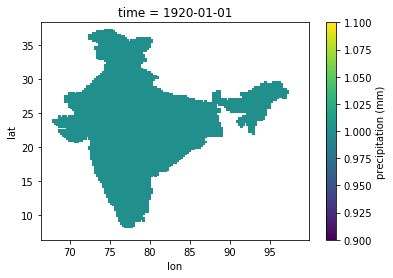

In [38]:
#xr_object.attrs['rcp'] = 'rcp_85'
mask[0:128,0:134].plot()

In [39]:
xr_object#[name_of_variable].max()

<xarray.Dataset>
Dimensions:                 (lat: 128, lon: 134, time: 34675)
Coordinates:
  * lat                     (lat) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25
  * lon                     (lon) float64 66.5 66.75 67.0 ... 99.25 99.5 99.75
  * time                    (time) object 2006-01-01 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    NorESM1_bcsrcnn_rcp_85  (time, lat, lon) float32 -0.0016142563 ... -0.0016142563
Attributes:
    units:    mm/day
    rcp:      rcp_85

In [40]:
masked_xr=xr_object*mask[0:128,0:134]

In [41]:
masked_xr.attrs['units'] = 'mm/day'
masked_xr.attrs['rcp'] = rcp_name
masked_xr


<xarray.Dataset>
Dimensions:                 (lat: 128, lon: 134, time: 34675)
Coordinates:
  * lat                     (lat) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25
  * lon                     (lon) float64 66.5 66.75 67.0 ... 99.25 99.5 99.75
  * time                    (time) object 2006-01-01 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    NorESM1_bcsrcnn_rcp_85  (time, lat, lon) float64 nan nan nan ... nan nan nan
Attributes:
    units:    mm/day
    rcp:      rcp_85

In [42]:
path='/home/madhumadi/bcsd_bcsrcnn/NorESM1_M/bcsrcnn/'

In [43]:
path+name_of_variable+'.nc'

'/home/madhumadi/bcsd_bcsrcnn/NorESM1_M/bcsrcnn/NorESM1_bcsrcnn_rcp_85.nc'

In [44]:
masked_xr[name_of_variable].clip(0).to_netcdf(path+name_of_variable+'.nc')

In [36]:
pwd

'/home/madhumadi/sd'

In [ ]:
masked_xr[name_of_variable][0].clip(0).plot()